# ETTh1 Univariate Forecasting (H=336)

This notebook implements the **Boosted Hybrid Model**:
- Sinusoidal Regressor (linear regression with sine/cos features)
- Residual modeling with XGBoost

Dataset: **ETTh1**, univariate forecasting with horizon H=336.


In [113]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

# For reproducibility
np.random.seed(42)


In [114]:

file_path = "/content/ETTh1.csv"

# Load the dataset
data = pd.read_csv(file_path)

print("Columns:", data.columns)
print("Shape:", data.shape)
data.head()


Columns: Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')
Shape: (17420, 8)


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [115]:
data.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000,17420.000000
mean,7.375141,2.242242,4.300239,0.881568,3.066062,0.856932,13.324672
std,7.067744,2.042342,6.826978,1.809293,1.164506,0.599552,8.566946
min,-22.705999,-4.756000,-25.087999,-5.934000,-1.188000,-1.371000,-4.080000
25%,5.827000,0.737000,3.296000,-0.284000,2.315000,0.670000,6.964000
50%,8.774000,2.210000,5.970000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.625000,1.218000,18.079000
max,23.643999,10.114000,17.341000,7.747000,8.498000,3.046000,46.007000


In [116]:
data.isnull().sum()

,0
date,0
HUFL,0
HULL,0
MUFL,0
MULL,0
LUFL,0
LULL,0
OT,0


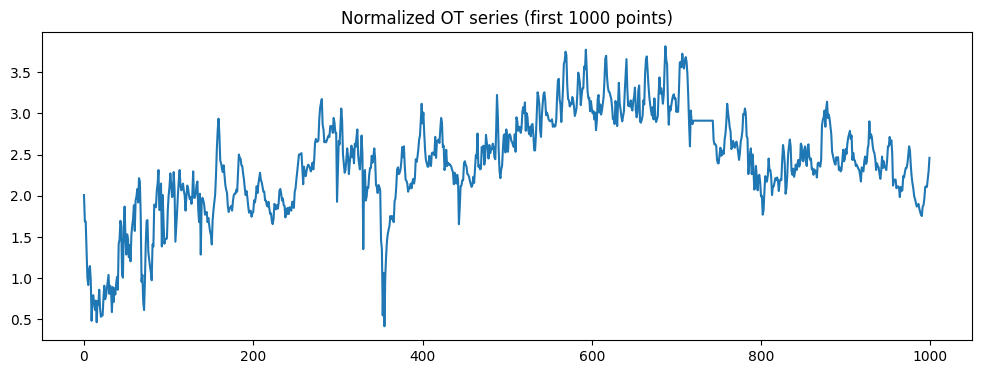

In [117]:

# Use univariate column (oil temperature: 'OT')
series = data['OT'].values

# Normalize (z-score)
mean, std = series.mean(), series.std()
series_norm = (series - mean) / std

plt.figure(figsize=(12,4))
plt.plot(series_norm[:1000])
plt.title("Normalized OT series (first 1000 points)")
plt.show()


In [118]:

def create_dataset(series, input_len=168, horizon=24):
    X, y = [], []
    for i in range(len(series) - input_len - horizon):
        X.append(series[i:i+input_len])
        y.append(series[i+input_len:i+input_len+horizon])
    return np.array(X), np.array(y)

# Configurable horizon
horizon = 336
input_len = 168  # past window length

# Assume series_norm is your normalized univariate series
X, y = create_dataset(series_norm, input_len, horizon)
print("X shape:", X.shape, "y shape:", y.shape)

# TS2Vec-style chronological split for ETTh1
# Each month ≈ 30 days * 24 hours = 720 time steps
train_end = 12 * 30 * 24   # 12 months
val_end   = 16 * 30 * 24   # 16 months (12+4)
test_end  = 20 * 30 * 24   # 20 months (12+4+4)

# Map indices to dataset windows
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:test_end], y[val_end:test_end]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)



X shape: (16916, 168) y shape: (16916, 336)
Train: (8640, 168) Val: (2880, 168) Test: (2880, 168)


In [119]:

def add_sin_features(n_samples, horizon, period=24):
    # For each time step ahead, add sin/cos with period
    t = np.arange(horizon)
    sin_feat = np.sin(2*np.pi*t/period)
    cos_feat = np.cos(2*np.pi*t/period)
    return np.vstack([sin_feat, cos_feat]).T

# Create features for sinusoidal regressor (same for all samples)
sin_features = add_sin_features(len(y_train), horizon)
print("Sinusoidal feature shape (per sample):", sin_features.shape)


Sinusoidal feature shape (per sample): (336, 2)


In [120]:

# Fit linear regression on sinusoidal features (predicts trend)
linreg = LinearRegression()
# Repeat features for all training samples
X_sin = np.tile(sin_features, (len(y_train),1))
y_train_flat = y_train.flatten()

linreg.fit(X_sin, y_train_flat)

# Predictions
y_train_pred_sin = linreg.predict(X_sin).reshape(len(y_train), horizon)


In [121]:

# Compute residuals
residuals = y_train - y_train_pred_sin

# Use lag features (X_train) for XGBoost
X_train_flat = X_train.reshape(len(X_train), -1)
residuals_flat = residuals.reshape(len(residuals), -1)

# Train XGBoost to predict residuals (multi-output: predict each horizon step separately)
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=5, tree_method='hist')
xgb_model.fit(X_train_flat, residuals_flat)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [122]:

def evaluate(X_set, y_set):
    # Sinusoidal prediction
    X_sin_eval = np.tile(sin_features, (len(y_set),1))
    y_pred_sin = linreg.predict(X_sin_eval).reshape(len(y_set), horizon)

    # Residual correction
    X_flat = X_set.reshape(len(X_set), -1)
    res_pred = xgb_model.predict(X_flat).reshape(len(y_set), horizon)

    y_pred = y_pred_sin + res_pred

    mse = mean_squared_error(y_set.flatten(), y_pred.flatten())
    mae = mean_absolute_error(y_set.flatten(), y_pred.flatten())
    return mse, mae, y_pred

mse_val, mae_val, _ = evaluate(X_val, y_val)
mse_test, mae_test, y_test_pred = evaluate(X_test, y_test)

print(f"Validation MSE: {mse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test MSE: {mse_test:.4f}, MAE: {mae_test:.4f}")


Validation MSE: 0.1561, MAE: 0.3125
Test MSE: 0.3829, MAE: 0.5414
